In [140]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent as StockDRLAgent
from finrl.agents.portfolio_optimization.models import DRLAgent as OptDRLAgent
from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

import numpy as np


TIME_WINDOW = 50
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# HISTORY DATA FOR SCRP
HISTORY_START_DATE = '2010-01-01'

TEST_START_DATE = '2017-01-01'
TEST_END_DATE = '2019-12-31'

EIIE_MODEL = "trained_eiie/policy_EIIE_2016-12-31_4_2024-11-29 22_30_01.pt"

GRAPH_TITLE = "EIIE Trained 2009-2016, 40 episodes"

# Backtest the results

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

TEST_TICKER = [
   "AMZN",
    "NKE",
    "DIS",
    "JPM",
    "IBM",
    "NVDA",
]

PORT = TEST_TICKER

df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = PORT).fetch_data()

processed = df.copy()
processed = processed.fillna(0)
processed_test = processed.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (4518, 8)


# Portfolio Optimization Algorithm

In [141]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed_test)
portfolio_norm_df


environment = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.21256263 0.15155448 0.35195291 0.3613764  0.20803501 0.15444612
 0.18067009 0.2942288  0.22891035 0.22158165 0.14211893 0.15338364
 0.20381527 0.16888017 0.17939632 0.23680048 0.21649864 0.18102626
 0.22621793 0.18938726 0.23242982 0.44373679 0.6561304  0.23527317
 0.20924238 0.17253245 0.15000906 0.14667069 0.25189254 0.16857229
 0.17922729 0.16388168 0.18788409 0.2117537  0.1579837  0.20899487
 0.22263809 0.16381527 0.16865077 0.1666224  0.12871114 0.1171808
 0.15758527 0.13568367 0.138032   0.12364624 0.1470812  0.11528524
 0.12862059 0.15467552 0.11121642 0.20431029 0.1378026  0.26458799
 0.16050106 0.11789919 0.12908542 0.16636281 0.18361606 0.27079988
 0.16677935 0.23891337 0.20659825 0.3009176  0.45326894 0.38298219
 0.22402053 0.19223061 0.1818

In [142]:
import torch
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
}


# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW, device=device)
policy.load_state_dict(torch.load(EIIE_MODEL, map_location=torch.device('cpu')))

C:\Users\bencj\AppData\Local\Temp\ipykernel_9688\2633074032.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load(EIIE_MODEL, map_location=t

<All keys matched successfully>

In [165]:
EIIE_results = {
    "test": {},
}

# 2021 - 2024
# Initialize the model
model = OptDRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)
OptDRLAgent.DRL_validation(model, environment, policy=policy)
EIIE_results["test"]["value"] = environment._asset_memory["final"]
EIIE_results["test"]["date"] = environment._date_memory



# Write this out to a csv file, with date and net worth
df_opt = pd.DataFrame(EIIE_results["test"]["value"], columns=['eiie_net_worth'])
df_date = pd.DataFrame(EIIE_results["test"]["date"], columns=['Date'])
if len(df_opt) == len(df_date):
    df_opt['Date'] = df_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")


# The optimization algoirhtm has a shorter window than the full df, so shorted this for the follow algorithm
opt_start = df_opt.loc[0,'Date']


Initial portfolio value:1000000
Final portfolio value: 1590973.5
Final accumulative portfolio value: 1.5909735
Maximum DrawDown: -0.26357746661774994
Sharpe ratio: 0.8653185959752843
Total commission cost: 18528.998887691996


In [144]:
print(df_opt)

     eiie_net_worth       Date
0      1.000000e+06 2017-03-15
1      1.000004e+06 2017-03-16
2      1.000010e+06 2017-03-17
3      1.000019e+06 2017-03-20
4      1.000009e+06 2017-03-21
..              ...        ...
699    1.616818e+06 2019-12-23
700    1.615746e+06 2019-12-24
701    1.620170e+06 2019-12-26
702    1.612788e+06 2019-12-27
703    1.590974e+06 2019-12-30

[704 rows x 2 columns]


In [145]:
opt_end = df_opt.loc[len(df_date)-1,'Date']

print(opt_start)
opt_start = opt_start.strftime('%Y-%m-%d %H:%M:%S')


print(opt_end)
opt_end = opt_end.strftime('%Y-%m-%d %H:%M:%S')

2017-03-15 00:00:00
2019-12-30 00:00:00


In [146]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

from finrl.meta.preprocessor.preprocessors import data_split

from datetime import datetime, timedelta
# Make sure dates line up
# Make sure we only test on the same data as the portfolio optimization algorithm
# Convert to datetime
opt_start_date = datetime.strptime(opt_start, '%Y-%m-%d %H:%M:%S')

# Subtract one day
new_opt_start_date = opt_start_date - timedelta(days=1)

# Convert back to string
new_opt_start_str = new_opt_start_date.strftime('%Y-%m-%d %H:%M:%S')

test_split = data_split(processed_test, new_opt_start_str,opt_end)

# DONT NORMALIZE PRICES FOR benchmarks with history
environment_benchmarks = PortfolioOptimizationEnv(
    test_split,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)



# PPO Model

In [147]:
from stable_baselines3 import PPO
from finrl.config import TRAINED_MODEL_DIR

TRAINED_PPO = "/train_2017/trained_models/agent_opt_ppo_update_test"

test_ppo_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(test_split)


trained_ppo_opt = PPO.load(TRAINED_MODEL_DIR + TRAINED_PPO) 


environment_ppo = PortfolioOptimizationEnv(
    test_ppo_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

PPO_results = {
    "test": {},
}

values, dates = DRLStableAgent.DRL_prediction(trained_ppo_opt, environment_ppo, deterministic=True)
PPO_results["test"]["value"] = environment_ppo._terminal_asset_memory["final"]
PPO_results["test"]["date"] = environment_ppo._terminal_date_memory


# Write this out to a csv file, with date and net worth
df_ppo_opt = pd.DataFrame(PPO_results["test"]["value"], columns=['ppo_opt_net_worth'])
df_ppo_date = pd.DataFrame(PPO_results["test"]["date"], columns=['Date'])
if len(df_ppo_opt) == len(df_ppo_date):
    df_ppo_opt['Date'] = df_ppo_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_ppo_opt)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.15467552 0.11121642 0.20431029 0.1378026  0.26458799 0.16050106
 0.11789919 0.12908542 0.16636281 0.18361606 0.27079988 0.16677935
 0.23891337 0.20659825 0.3009176  0.45326894 0.38298219 0.22402053
 0.19223061 0.18187142 0.14827045 0.19164503 0.17233323 0.18105644
 0.17326894 0.16990039 0.14612134 0.188524   0.20408089 0.15749472
 0.32028373 0.44459402 0.33000302 0.23234531 0.21628132 0.14599457
 0.17303954 0.20619982 0.19692726 0.12656203 0.13245397 0.21888922
 0.25780863 0.18871717 0.31063085 0.23780863 0.23978871 0.15950498
 0.14582554 0.14766073 0.29109568 0.20942952 0.19698762 0.23622698
 0.14819197 0.22651977 0.16419559 0.2020163  0.17041956 0.16709327
 0.46167824 0.5703109  0.27648657 0.23995774 0.32441292 0.69258678
 0.30446121 0.24610927 0.176

Initial portfolio value:1000000
Final portfolio value: 1408807.875
Final accumulative portfolio value: 1.408807875
Maximum DrawDown: -0.23006717028380397
Sharpe ratio: 0.8518088502571651
Total commission cost: 12694.853931518854
hit end!
     ppo_opt_net_worth       Date
0         1.000000e+06 2017-03-15
1         1.001753e+06 2017-03-16
2         9.978171e+05 2017-03-17
3         1.001013e+06 2017-03-20
4         9.864641e+05 2017-03-21
..                 ...        ...
699       1.410071e+06 2019-12-23
700       1.411151e+06 2019-12-24
701       1.425275e+06 2019-12-26
702       1.426664e+06 2019-12-27
703       1.408808e+06 2019-12-30

[704 rows x 2 columns]


# Porfolio Baselines

In [148]:
# CRP 

CRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_crp = DRLStableAgent(env = environment_benchmarks)
model_crp = agent_crp.get_model("crp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_crp, environment_benchmarks)
CRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
CRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_crp_opt = pd.DataFrame(CRP_results["test"]["value"], columns=['crp_opt_net_worth'])
df_crp_date = pd.DataFrame(CRP_results["test"]["date"], columns=['Date'])
if len(df_crp_opt) == len(df_crp_date):
    df_crp_opt['Date'] = df_crp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_crp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_crp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_crp_opt.loc[len(df_crp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1684568.5
Final accumulative portfolio value: 1.6845685
Maximum DrawDown: -0.2887110457630121
Sharpe ratio: 1.1123952882866477
Total commission cost: 8011.511028953013
hit end!
     crp_opt_net_worth       Date
0         1.000000e+06 2017-03-15
1         1.002916e+06 2017-03-16
2         1.003738e+06 2017-03-17
3         1.012792e+06 2017-03-20
4         9.945479e+05 2017-03-21
..                 ...        ...
699       1.686258e+06 2019-12-23
700       1.686484e+06 2019-12-24
701       1.704880e+06 2019-12-26
702       1.705748e+06 2019-12-27
703       1.684568e+06 2019-12-30

[704 rows x 2 columns]


In [149]:
# BAH

BAH_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt = pd.DataFrame(BAH_results["test"]["value"], columns=['bah_opt_net_worth'])
df_bah_date = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
if len(df_bah_opt) == len(df_bah_date):
    df_bah_opt['Date'] = df_bah_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bah_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bah_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bah_opt.loc[len(df_bah_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1678859.0
Final accumulative portfolio value: 1.678859
Maximum DrawDown: -0.33046096366657274
Sharpe ratio: 1.016247320349258
Total commission cost: 0.0
hit end!
     bah_opt_net_worth       Date
0         1.000000e+06 2017-03-15
1         1.002916e+06 2017-03-16
2         1.003773e+06 2017-03-17
3         1.013002e+06 2017-03-20
4         9.946696e+05 2017-03-21
..                 ...        ...
699       1.678284e+06 2019-12-23
700       1.678594e+06 2019-12-24
701       1.700185e+06 2019-12-26
702       1.699805e+06 2019-12-27
703       1.678859e+06 2019-12-30

[704 rows x 2 columns]


In [150]:
# OLMAR

OLMAR_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_olmar = DRLStableAgent(env = environment_benchmarks)
model_olmar = agent_olmar.get_model("olmar", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_olmar, environment_benchmarks)
OLMAR_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
OLMAR_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_olmar_opt = pd.DataFrame(OLMAR_results["test"]["value"], columns=['olmar_opt_net_worth'])
df_olmar_date = pd.DataFrame(OLMAR_results["test"]["date"], columns=['Date'])
if len(df_olmar_opt) == len(df_olmar_date):
    df_olmar_opt['Date'] = df_olmar_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_olmar_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_olmar_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_olmar_opt.loc[len(df_olmar_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 809147.5
Final accumulative portfolio value: 0.8091475
Maximum DrawDown: -0.43222962587496017
Sharpe ratio: -0.0737625869877641
Total commission cost: 653596.7380754082
hit end!
     olmar_opt_net_worth       Date
0           1.000000e+06 2017-03-15
1           1.002916e+06 2017-03-16
2           1.023046e+06 2017-03-17
3           1.055646e+06 2017-03-20
4           1.021503e+06 2017-03-21
..                   ...        ...
699         8.219582e+05 2019-12-23
700         8.237738e+05 2019-12-24
701         8.260985e+05 2019-12-26
702         8.266471e+05 2019-12-27
703         8.091475e+05 2019-12-30

[704 rows x 2 columns]


In [151]:
# RMR

RMR_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_rmr = DRLStableAgent(env = environment_benchmarks)
model_rmr = agent_rmr.get_model("rmr", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_rmr, environment_benchmarks)
RMR_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
RMR_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_rmr_opt = pd.DataFrame(RMR_results["test"]["value"], columns=['rmr_opt_net_worth'])
df_rmr_date = pd.DataFrame(RMR_results["test"]["date"], columns=['Date'])
if len(df_rmr_opt) == len(df_rmr_date):
    df_rmr_opt['Date'] = df_rmr_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_rmr_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_rmr_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_rmr_opt.loc[len(df_rmr_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1546375.5
Final accumulative portfolio value: 1.5463755
Maximum DrawDown: -0.5379134890855172
Sharpe ratio: 0.6065425697459185
Total commission cost: 11618.35295059823
hit end!
     rmr_opt_net_worth       Date
0         1.000000e+06 2017-03-15
1         1.002916e+06 2017-03-16
2         1.023046e+06 2017-03-17
3         1.055646e+06 2017-03-20
4         1.021503e+06 2017-03-21
..                 ...        ...
699       1.589642e+06 2019-12-23
700       1.588310e+06 2019-12-24
701       1.592104e+06 2019-12-26
702       1.576661e+06 2019-12-27
703       1.546376e+06 2019-12-30

[704 rows x 2 columns]


In [152]:
# BNN

BNN_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bnn = DRLStableAgent(env = environment_benchmarks)
model_bnn = agent_bnn.get_model("bnn", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_bnn, environment_benchmarks)
BNN_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BNN_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bnn_opt = pd.DataFrame(BNN_results["test"]["value"], columns=['bnn_opt_net_worth'])
df_bnn_date = pd.DataFrame(BNN_results["test"]["date"], columns=['Date'])
if len(df_bnn_opt) == len(df_bnn_date):
    df_bnn_opt['Date'] = df_bnn_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bnn_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bnn_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bnn_opt.loc[len(df_bnn_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1519132.625
Final accumulative portfolio value: 1.519132625
Maximum DrawDown: -0.5478666537078434
Sharpe ratio: 0.5929555881462771
Total commission cost: 9243.789287401945
hit end!
     bnn_opt_net_worth       Date
0          1000000.000 2017-03-15
1          1000000.000 2017-03-16
2          1000000.000 2017-03-17
3          1000000.000 2017-03-20
4          1000000.000 2017-03-21
..                 ...        ...
699        1561636.500 2019-12-23
700        1560328.375 2019-12-24
701        1564055.500 2019-12-26
702        1548884.750 2019-12-27
703        1519132.625 2019-12-30

[704 rows x 2 columns]


In [153]:
# SCRP

# Download the history data for scrp

history_df = YahooDownloader(start_date = HISTORY_START_DATE,
                     end_date = opt_start_date,
                     ticker_list = PORT).fetch_data()

# Dont normalize the price data here

SCRP_hist_results = {
    "test": {},
}

history_df_environment = PortfolioOptimizationEnv(
        history_df,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close"],
        normalize_df=None
    )

# Pull out the historical price data for SCRP over the training period
agent_history_scrp = DRLStableAgent(env = history_df_environment)
history_scrp = agent_history_scrp.get_model("scrp")

_, _ = DRLStableAgent.DRL_prediction(history_scrp, history_df_environment)


# now make the predictions with the historical price data, but in the test period only
SCRP_model_kwargs = {
    "price_history": history_scrp.price_history
}

print(history_scrp.price_history)

environment_benchmarks.reset()
agent_scrp_hist = DRLStableAgent(env = environment_benchmarks)
model_scrp_hist = agent_scrp_hist.get_model("scrp", model_kwargs=SCRP_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_scrp_hist, environment_benchmarks)
SCRP_hist_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
SCRP_hist_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_scrp_hist_opt = pd.DataFrame(SCRP_hist_results["test"]["value"], columns=['scrp_hist_opt_net_worth'])
df_scrp_hist_date = pd.DataFrame(SCRP_hist_results["test"]["date"], columns=['Date'])
if len(df_scrp_hist_opt) == len(df_scrp_hist_date):
    df_scrp_hist_opt['Date'] = df_scrp_hist_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_scrp_hist_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_scrp_hist_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_scrp_hist_opt.loc[len(df_scrp_hist_opt)-1,'Date']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Shape of DataFrame:  (10866, 8)
Initial portfolio value:1000000
Final portfolio value: 2924110.25
Final accumulative portfolio value: 2.92411025
Maximum DrawDown: -0.2947792877449932
Sharpe ratio: 0.7135404681128295
Total commission cost: 16308.297952401801
hit end!
              0           1           2          3          4         5
0      6.695000   27.715311   74.764565  29.156563  13.647312  0.423952
1      6.734500   27.646175   73.861420  29.721325  13.701610  0.430143
2      6.612500   27.499260   73.381622  29.884609  13.618075  0.432894
3      6.500000   27.507902   73.127602  30.476606  13.751727  0.424410
4      6.676000   27.551113   73.861420  30.401758  13.724583  0.425328
...         ...         ...         ...        ...        ...       ...
1806  42.525002  105.311951  120.429939  73.567619  51.939377  2.431140
1807  42.650002  105.492485  118.906570  73.857994  51.801506  2.430645
1808  42.623001  105.387970  119.342751  73.624077  51.865837  2.444953
1809  42.7295

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 2165246.75
Final accumulative portfolio value: 2.16524675
Maximum DrawDown: -0.341037913199421
Sharpe ratio: 1.1232348134309795
Total commission cost: 0.029680576059035957
hit end!
     scrp_hist_opt_net_worth       Date
0               1.000000e+06 2017-03-15
1               1.000528e+06 2017-03-16
2               9.992263e+05 2017-03-17
3               1.004690e+06 2017-03-20
4               9.885459e+05 2017-03-21
..                       ...        ...
699             2.102068e+06 2019-12-23
700             2.097624e+06 2019-12-24
701             2.190898e+06 2019-12-26
702             2.192106e+06 2019-12-27
703             2.165247e+06 2019-12-30

[704 rows x 2 columns]


In [154]:
# SCRP - no history

SCRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_scrp = DRLStableAgent(env = environment_benchmarks)
model_scrp = agent_scrp.get_model("scrp", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_scrp, environment_benchmarks)
SCRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
SCRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_scrp_opt = pd.DataFrame(SCRP_results["test"]["value"], columns=['scrp_opt_net_worth'])
df_scrp_date = pd.DataFrame(SCRP_results["test"]["date"], columns=['Date'])
if len(df_scrp_opt) == len(df_scrp_date):
    df_scrp_opt['Date'] = df_scrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_scrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_scrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_scrp_opt.loc[len(df_scrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1738825.25
Final accumulative portfolio value: 1.73882525
Maximum DrawDown: -0.5603846467047087
Sharpe ratio: 0.6847622239801598
Total commission cost: 5611.085414232803
hit end!
     scrp_opt_net_worth       Date
0          1.000000e+06 2017-03-15
1          1.002916e+06 2017-03-16
2          1.023046e+06 2017-03-17
3          1.055646e+06 2017-03-20
4          1.021503e+06 2017-03-21
..                  ...        ...
699        1.787476e+06 2019-12-23
700        1.785978e+06 2019-12-24
701        1.790245e+06 2019-12-26
702        1.772880e+06 2019-12-27
703        1.738825e+06 2019-12-30

[704 rows x 2 columns]


# Try BCRP extreme, which is the absolute best portfolio over the period with hindsight


In [155]:
# bcrp

BCRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bcrp= DRLStableAgent(env = environment_benchmarks)
model_bcrp= agent_bcrp.get_model("bcrp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bcrp, environment_benchmarks)
BCRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BCRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bcrp_opt = pd.DataFrame(BCRP_results["test"]["value"], columns=['bcrp_opt_net_worth'])
df_bcrp_date = pd.DataFrame(BCRP_results["test"]["date"], columns=['Date'])
if len(df_bcrp_opt) == len(df_bcrp_date):
    df_bcrp_opt['Date'] = df_bcrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bcrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bcrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bcrp_opt.loc[len(df_bcrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 2331621.75
Final accumulative portfolio value: 2.33162175
Maximum DrawDown: -0.48445760882089317
Sharpe ratio: 1.046539521716816
Total commission cost: 9263.283323655254
hit end!
     bcrp_opt_net_worth       Date
0          1.000000e+06 2017-03-15
1          1.008090e+06 2017-03-16
2          1.021732e+06 2017-03-17
3          1.044654e+06 2017-03-20
4          1.016921e+06 2017-03-21
..                  ...        ...
699        2.347986e+06 2019-12-23
700        2.344944e+06 2019-12-24
701        2.385755e+06 2019-12-26
702        2.371296e+06 2019-12-27
703        2.331622e+06 2019-12-30

[704 rows x 2 columns]


# Stock environment optimization algorithm

In [156]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_date.loc[0,'Date'],
        end = df_date.loc[len(df_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * INITIAL_CASH
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (703, 8)
Annual return          0.118673
Cumulative returns     0.367309
Annual volatility      0.135165
Sharpe ratio           0.898764
Calmar ratio           0.632187
Stability              0.773470
Max drawdown          -0.187719
Omega ratio            1.183500
Sortino ratio          1.224511
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.879500
Daily value at risk   -0.016547
dtype: float64
df_dji:            date           dji
0   2017-03-15  1.000000e+06
1   2017-03-16  9.992578e+05
2   2017-03-17  9.983064e+05
3   2017-03-20  9.978883e+05
4   2017-03-21  9.865352e+05
..         ...           ...
699 2019-12-23  1.362835e+06
700 2019-12-24  1.361113e+06
701 2019-12-26  1.366170e+06
702 2019-12-27  1.367309e+06
703 2019-12-30           NaN

[704 rows x 2 columns]
df_dji:                       dji
date                    
2017-03-15  1.000000e+06
2017-03-16  9.992578e+05
2017-03-17  9.983064e+05
2017-03-20  9.978883e+05

# Compare all results

In [157]:
# Join the online algorithms

# bcrp = pd.read_csv('BCRP_net_worth.csv')
# crp = pd.read_csv('CRP_net_worth.csv')


# Merge the baseline CRP algorithm
df_crp_opt['Date'] = pd.to_datetime(df_crp_opt['Date'])
merged_df = df_crp_opt

# Merge the baseline BCRP algorithm
df_bcrp_opt['Date'] = pd.to_datetime(df_bcrp_opt['Date'])
merged_df = pd.merge(merged_df, df_bcrp_opt, on='Date')

# Merge the baseline BAH algorithm
df_bah_opt['Date'] = pd.to_datetime(df_bah_opt['Date'])
merged_df = pd.merge(merged_df, df_bah_opt, on='Date')

# Merge the baseline OLMAR algorithm
df_olmar_opt['Date'] = pd.to_datetime(df_olmar_opt['Date'])
merged_df = pd.merge(merged_df, df_olmar_opt, on='Date')

# Merge the baseline RMR algorithm
df_rmr_opt['Date'] = pd.to_datetime(df_rmr_opt['Date'])
merged_df = pd.merge(merged_df, df_rmr_opt, on='Date')

# Merge the baseline BNN algorithm
df_bnn_opt['Date'] = pd.to_datetime(df_bnn_opt['Date'])
merged_df = pd.merge(merged_df, df_bnn_opt, on='Date')

# Merge the baseline SCRP algorithm
df_scrp_opt['Date'] = pd.to_datetime(df_scrp_opt['Date'])
merged_df = pd.merge(merged_df, df_scrp_opt, on='Date')

# Merge the baseline SCRP hist algorithm
df_scrp_hist_opt['Date'] = pd.to_datetime(df_scrp_hist_opt['Date'])
merged_df = pd.merge(merged_df, df_scrp_hist_opt, on='Date')

# Merge the opt algorithm
df_opt['Date'] = pd.to_datetime(df_opt['Date'])
merged_df = pd.merge(merged_df, df_opt, on='Date')

# Merge the PPO algorithm
df_ppo_opt['Date'] = pd.to_datetime(df_ppo_opt['Date'])
merged_df = pd.merge(merged_df, df_ppo_opt, on='Date')



print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2017-03-15  1.000000e+06
2017-03-16  9.992578e+05
2017-03-17  9.983064e+05
2017-03-20  9.978883e+05
2017-03-21  9.865352e+05
...                  ...
2019-12-23  1.362835e+06
2019-12-24  1.361113e+06
2019-12-26  1.366170e+06
2019-12-27  1.367309e+06
2019-12-30           NaN

[704 rows x 1 columns]
     crp_opt_net_worth       Date  bcrp_opt_net_worth  bah_opt_net_worth  \
0         1.000000e+06 2017-03-15        1.000000e+06       1.000000e+06   
1         1.002916e+06 2017-03-16        1.008090e+06       1.002916e+06   
2         1.003738e+06 2017-03-17        1.021732e+06       1.003773e+06   
3         1.012792e+06 2017-03-20        1.044654e+06       1.013002e+06   
4         9.945479e+05 2017-03-21        1.016921e+06       9.946696e+05   
..                 ...        ...                 ...                ...   
699       1.686258e+06 2019-12-23        2.347986e+06       1.678284e+06   
700       1.686484e+06 2019-12-24        2.

# Baseline CRP in the environment

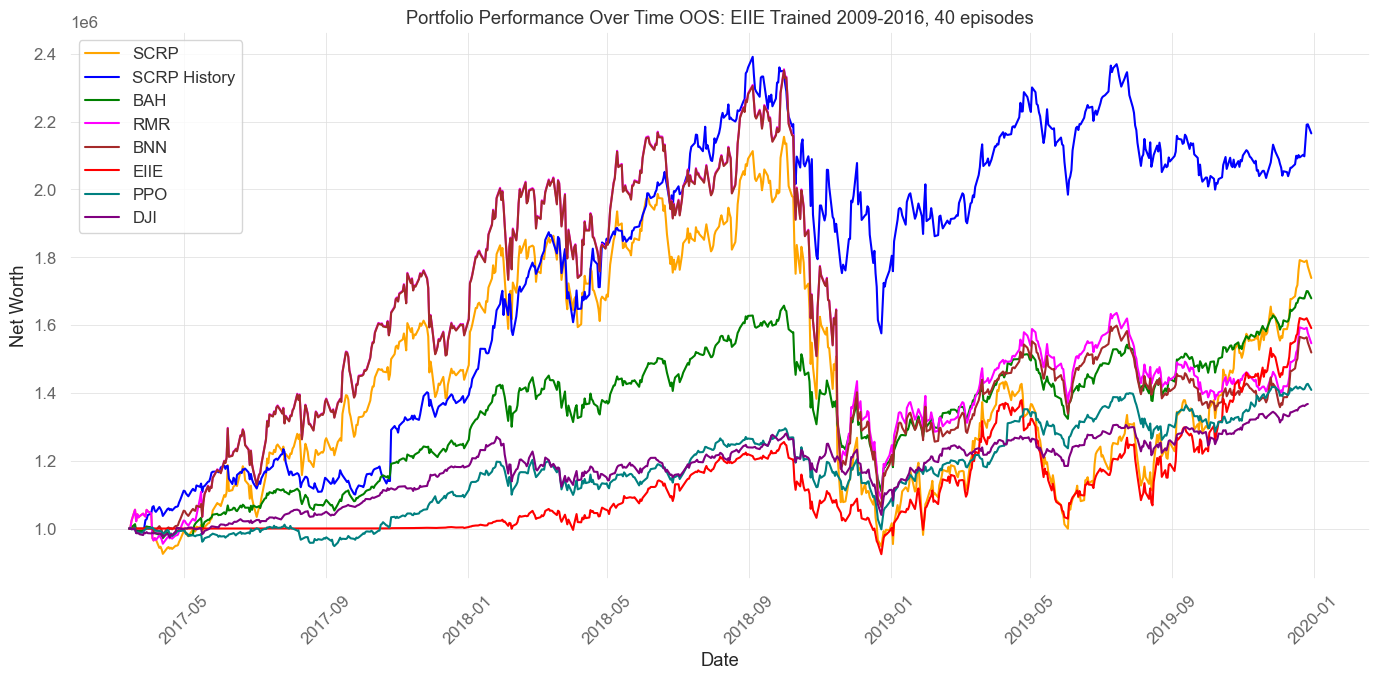

In [158]:
# Use the correct backend for Jupyter
%matplotlib inline
import matplotlib.pyplot as plt

# TODO make sure all dates line up, fix CRP and OLMAR 

import matplotlib.pyplot as plt

# Define a color map for the labels
color_map = {
    'BAH': 'green',
    'EIIE': 'red',
    'PPO': 'teal',
    'DJI': 'purple',
    'SCRP': 'orange',
    'SCRP History': 'blue',
    'OLMAR': 'cyan',
    'RMR': 'magenta',
    'BNN': 'brown'
}




plt.figure(figsize=(14, 7))
# plt.plot(merged_df['Date'], merged_df['crp_opt_net_worth'], label='CRP', color=color_map['CRP'])
plt.plot(merged_df['Date'], merged_df['scrp_opt_net_worth'], label='SCRP', color=color_map['SCRP'])
plt.plot(merged_df['Date'], merged_df['scrp_hist_opt_net_worth'], label='SCRP History', color=color_map['SCRP History'])
plt.plot(merged_df['Date'], merged_df['bah_opt_net_worth'], label='BAH', color=color_map['BAH'])
# plt.plot(merged_df['Date'], merged_df['olmar_opt_net_worth'], label='OLMAR', color=color_map['OLMAR'])
plt.plot(merged_df['Date'], merged_df['rmr_opt_net_worth'], label='RMR', color=color_map['RMR'])
plt.plot(merged_df['Date'], merged_df['bnn_opt_net_worth'], label='BNN', color=color_map['BNN'])
plt.plot(merged_df['Date'], merged_df['eiie_net_worth'], label='EIIE', color=color_map['EIIE'])
plt.plot(merged_df['Date'], merged_df['ppo_opt_net_worth'], label='PPO', color=color_map['PPO'])
plt.plot(merged_df['Date'], merged_df['dji'], label='DJI', color=color_map['DJI'])
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time OOS: ' + GRAPH_TITLE)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [159]:
import pprint

final_returns = {
   'BCRP OPT': merged_df['bcrp_opt_net_worth'].iloc[-1],
    'CRP': merged_df['crp_opt_net_worth'].iloc[-1],
    'SCRP': merged_df['scrp_opt_net_worth'].iloc[-1],
    'Hist. SCRP': merged_df['scrp_hist_opt_net_worth'].iloc[-1],
    'BAH': merged_df['bah_opt_net_worth'].iloc[-1],
    'OLMAR': merged_df['olmar_opt_net_worth'].iloc[-1],
    'RMR': merged_df['rmr_opt_net_worth'].iloc[-1],
    'BNN': merged_df['bnn_opt_net_worth'].iloc[-1],
    'EIIE': merged_df['eiie_net_worth'].iloc[-1],
    'PPO': merged_df['ppo_opt_net_worth'].iloc[-1],
}

pprint.pprint(final_returns)

{'BAH': 1678859.0,
 'BCRP OPT': 2331621.75,
 'BNN': 1519132.625,
 'CRP': 1684568.5,
 'EIIE': 1590973.5,
 'Hist. SCRP': 2165246.75,
 'OLMAR': 809147.5,
 'PPO': 1408807.875,
 'RMR': 1546375.5,
 'SCRP': 1738825.25}


In [160]:
import numpy as np
import pprint

# Calculate the returns each day

# merged_df['BCRP_daily_return'] = merged_df['BCRP_net_worth'].pct_change()
# merged_df['CRP_daily_return'] = merged_df['CRP_net_worth'].pct_change()
merged_df['BCRP_opt_daily_return'] = merged_df['bcrp_opt_net_worth'].pct_change()
merged_df['CRP_opt_daily_return'] = merged_df['crp_opt_net_worth'].pct_change()
merged_df['SCRP_opt_daily_return'] = merged_df['scrp_opt_net_worth'].pct_change()
merged_df['SCRP_hist_opt_daily_return'] = merged_df['scrp_hist_opt_net_worth'].pct_change()


merged_df['BAH_opt_daily_return'] = merged_df['bah_opt_net_worth'].pct_change()
merged_df['OLMAR_opt_daily_return'] = merged_df['olmar_opt_net_worth'].pct_change()
merged_df['RMR_opt_daily_return'] = merged_df['rmr_opt_net_worth'].pct_change()
merged_df['BNN_opt_daily_return'] = merged_df['bnn_opt_net_worth'].pct_change()

merged_df['EIIE_daily_return'] = merged_df['eiie_net_worth'].pct_change()
merged_df['PPO_daily_return'] = merged_df['ppo_opt_net_worth'].pct_change()


# merged_df['OLMAR_daily_return'] = merged_df['OLMAR_net_worth'].pct_change()


# TODO need to put in the fama french

# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    # 'BCRP': calculate_sharpe_ratio(merged_df['BCRP_daily_return'], risk_free_rate),
    # 'CRP': calculate_sharpe_ratio(merged_df['CRP_daily_return'], risk_free_rate),
    'BCRP': calculate_sharpe_ratio(merged_df['BCRP_opt_daily_return'], risk_free_rate),
    'CRP': calculate_sharpe_ratio(merged_df['CRP_opt_daily_return'], risk_free_rate),
    'SCRP': calculate_sharpe_ratio(merged_df['SCRP_opt_daily_return'], risk_free_rate),
    'Hist. SCRP': calculate_sharpe_ratio(merged_df['SCRP_hist_opt_daily_return'], risk_free_rate),
    'BAH': calculate_sharpe_ratio(merged_df['BAH_opt_daily_return'], risk_free_rate),
    'OLMAR': calculate_sharpe_ratio(merged_df['OLMAR_opt_daily_return'], risk_free_rate),
    'RMR': calculate_sharpe_ratio(merged_df['RMR_opt_daily_return'], risk_free_rate),
    'BNN': calculate_sharpe_ratio(merged_df['BNN_opt_daily_return'], risk_free_rate),
    'EIIE': calculate_sharpe_ratio(merged_df['EIIE_daily_return'], risk_free_rate),
    'PPO': calculate_sharpe_ratio(merged_df['PPO_daily_return'], risk_free_rate),
    # 'OLMAR old': calculate_sharpe_ratio(merged_df['OLMAR_daily_return'], risk_free_rate),
    # 'Opt': calculate_sharpe_ratio(merged_df['opt_daily_return'], risk_free_rate),

}

pprint.pprint(sharpe_ratios)

{'BAH': 0.9184590535443798,
 'BCRP': 0.9898529528176947,
 'BNN': 0.5393170647230698,
 'CRP': 1.0039486368576014,
 'EIIE': 0.7751429605981836,
 'Hist. SCRP': 1.0529991500531783,
 'OLMAR': -0.13588431013453187,
 'PPO': 0.7266281798566674,
 'RMR': 0.5537788809462112,
 'SCRP': 0.6377419828027253}


In [161]:
import pandas as pd
import numpy as np

# Assuming merged_df is your DataFrame
# Calculate the max drawdown for each specified column
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

max_drawdowns = {
    # 'BCRP': max_drawdown(merged_df['BCRP_net_worth']),
    # 'CRP': max_drawdown(merged_df['CRP_net_worth']),
    'BCRP': max_drawdown(merged_df['bcrp_opt_net_worth']),
    'CRP': max_drawdown(merged_df['crp_opt_net_worth']),
    'SCRP': max_drawdown(merged_df['scrp_opt_net_worth']),
    'Hist. SCRP': max_drawdown(merged_df['scrp_hist_opt_net_worth']),
    'BAH': max_drawdown(merged_df['bah_opt_net_worth']),
    'OLMAR': max_drawdown(merged_df['olmar_opt_net_worth']),
    'RMR': max_drawdown(merged_df['rmr_opt_net_worth']),
    'BNN': max_drawdown(merged_df['bnn_opt_net_worth']),
    'EIIE': max_drawdown(merged_df['eiie_net_worth']),
    'PPO': max_drawdown(merged_df['ppo_opt_net_worth']),
    # 'Opt': max_drawdown(merged_df['opt_net_worth']),
}

pprint.pprint(max_drawdowns)


{'BAH': -0.33046096366657274,
 'BCRP': -0.48445760882089317,
 'BNN': -0.5478666537078434,
 'CRP': -0.2887110457630121,
 'EIIE': -0.26357746661774994,
 'Hist. SCRP': -0.341037913199421,
 'OLMAR': -0.43222962587496017,
 'PPO': -0.23006717028380397,
 'RMR': -0.5379134890855172,
 'SCRP': -0.5603846467047087}


In [162]:
import numpy as np
import pandas as pd

# Define a function to calculate the ratio of up days
def calculate_up_days_ratio(series):
    up_days = (series > 0).sum()
    total_days = series.count()
    return up_days / total_days if total_days > 0 else 0

# Calculate the ratio of up days for each daily return column
up_days_ratios = {
    'BCRP': calculate_up_days_ratio(merged_df['BCRP_opt_daily_return']),
    'CRP': calculate_up_days_ratio(merged_df['CRP_opt_daily_return']),
    'SCRP': calculate_up_days_ratio(merged_df['SCRP_opt_daily_return']),
    'Hist. SCRP': calculate_up_days_ratio(merged_df['SCRP_hist_opt_daily_return']),
    'BAH': calculate_up_days_ratio(merged_df['BAH_opt_daily_return']),
    'OLMAR': calculate_up_days_ratio(merged_df['OLMAR_opt_daily_return']),
    'RMR': calculate_up_days_ratio(merged_df['RMR_opt_daily_return']),
    'BNN': calculate_up_days_ratio(merged_df['BNN_opt_daily_return']),
    'EIIE': calculate_up_days_ratio(merged_df['EIIE_daily_return']),
    'PPO': calculate_up_days_ratio(merged_df['PPO_daily_return']),
}

pprint.pprint(up_days_ratios)




{'BAH': 0.5604551920341394,
 'BCRP': 0.5561877667140825,
 'BNN': 0.5220483641536273,
 'CRP': 0.5647226173541963,
 'EIIE': 0.5590327169274538,
 'Hist. SCRP': 0.5547652916073968,
 'OLMAR': 0.5106685633001422,
 'PPO': 0.5547652916073968,
 'RMR': 0.534850640113798,
 'SCRP': 0.534850640113798}


In [163]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols


# TODO can we do a statisitical significance test with anova here?
ANOVA_cols = ['EIIE_daily_return', 'BAH_opt_daily_return']
cols = ['Date',] + ANOVA_cols


df_selected = merged_df[cols]

# Assuming merged_df is your DataFrame and daily returns have already been calculated
# Combine all return columns into one DataFrame for ANOVA
returns_long = df_selected.melt(
    id_vars=['Date'], 
    value_vars=ANOVA_cols,
    var_name='Portfolio', 
    value_name='Daily_Return'
)

# Remove any NaN values created by pct_change()
returns_long.dropna(inplace=True)

# Perform ANOVA
model = ols('Daily_Return ~ Portfolio', data=returns_long).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Display the summary of the ANOVA
pprint.pprint(anova_result)

# The results do seem to be statisitcally significant


             sum_sq      df         F    PR(>F)
Portfolio  0.000001     1.0  0.007676  0.930196
Residual   0.249989  1404.0       NaN       NaN


In [164]:
from scipy import stats

df_ppo = merged_df['EIIE_daily_return'].dropna() 
df_bah = merged_df['BAH_opt_daily_return'].dropna()

print(df_bah)

t_stat, p_value = stats.ttest_ind(df_ppo, df_bah) 

print(f"t-statistic: {t_stat}") 
print(f"p-value: {p_value}")

1      0.002916
2      0.000855
3      0.009194
4     -0.018097
5     -0.005794
         ...   
699   -0.001747
700    0.000184
701    0.012863
702   -0.000224
703   -0.012322
Name: BAH_opt_daily_return, Length: 703, dtype: float64
t-statistic: -0.08761421916494441
p-value: 0.9301957944198502
